# Datenauswertung der Windkraftanlage Egneos Wind1


Webseite: http://egneos.de/portfoli/projekt-neos-wind-1/

Lage: http://www.openstreetmap.org/node/3996237479#map=15/51.3463/13.3807

Typ: Enercon E-101 http://www.enercon.de/produkte/ep-3/e-101/
* 135m Mast
* 101m Rotordurchmesser
* 3.05 MW
* Bauart: getriebelos, variable Drehzahl, Einzelblattverstellung
* Baujahr 2015

Dokumentation und Quelltext:
https://github.com/kolossos/energy-tests/blob/master/Dokumente/energy/PyOPC-visualizeSQLite3.ipynb

## Motivation für die Datenauswertung:

>Man besitzt nur das, was man aufschrauben und wo man reinschauen kann.

* Mehr als nur Freude an einer ggf. kommenden Rendite
* Begeisterung an faszinierender Technik (3MW sind beeindruckend. Kein Sportwagen mit solch einer Leistung.)
* Die Anlage ist eine nette "kleine" Wetterstation
* (Anlagenmonitoring) . Das macht aktiv der Hersteller.
* Interesse an Datenanalyse (insbesonders der physikalischen Zusammenhänge.) 
* Interesse an Industriesteuerungen
* Analyse des detailierten Zeitverlaufs
* Die Energiewende verstehen und unterstützen
* Hoffnung ggf. Begeisterung bei anderen zu wecken

## Vorgehensweise
* über VPN Zugriff auf die Anlage
* Kommunikation mit dem Scada-System über OPC XML-DA mittels PyOPC 
* Genutzt wird Python, Ipython-Notebook, Pandas
* Alles in eine Datenbank (SQLite) schreiben
* Datenvisualisierung über Matplotlib

### Gespeichert werden:
* Anlagedaten
 * Windgeschwindigkeit und Windrichtung
 * Rotordrehzahl und Pitchwinkel
 * Leistung
 * Stromzähler
 * Betriebstunden
 * Blindstrom
 
* Temperaturdaten
 * 25 Sensoren in der Gondel 
 * 14 Sensoren in den Elektroschränken unten im Mast
* Verfügbarkeitsdaten 

Historische Daten werden aggregiert als Min, Max und Mittelwert gespeichert. Alle Datensätze mit Zeitstempel (UTC).

### Neben der Angabe von Live-Daten, speichert die Anlage Daten für eine jeweils bestimmte Zeit:
* RAW-Daten minütlich für die letzten 12 Stunden
* REP-Daten aller 10 Minuten für die letzten 2 Tage
* DAY-Daten täglich für 60 Tage 
* Week-Daten wöchentlich für 54 Wochen
* Month-Daten monatlich für 36 Monate
* Year-Daten jährlich für 10 Jahre

In [1]:
#!/usr/bin/env python
%matplotlib inline

#from PyOPC.OPCContainers import *
#from PyOPC.XDAClient import XDAClient

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from sqlalchemy import create_engine # database connection
import datetime as dt
from IPython.display import display
from IPython.display import clear_output

import scipy.stats

#http://pyopc.sourceforge.net/
#https://plot.ly/python/big-data-analytics-with-pandas-and-sqlite/

## Daten der letzten 12 Stunden

In [4]:
disk_engine = create_engine('sqlite:///egneos2.db')

In [5]:
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Raw limit 720 offset (select count(*) FROM Wecstd_Raw)-720'
                       , disk_engine)
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
pd.read_sql_query('SELECT Count(*) '
                       'FROM Wecstd_Raw '
                       , disk_engine)

,Count(*)
0,298496


In [6]:
df.head()

,Source,Values,MitVwind,MaxVwind,MinVwind,MitNRotor,MaxNRotor,MinNRotor,MitP,MaxP,...,PavaExtern,Pitch,?1,?2,?3,?4,?5,?6,?7,?8
2016-09-23 03:54:00,Raw,1.0,3.6,5.5,0.9,0.84,0.88,0.82,0.0,0.0,...,35.0,60.089999,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0.0,65535.0
2016-09-23 03:55:00,Raw,1.0,3.7,5.6,0.9,0.85,0.88,0.83,-1.0,-1.0,...,42.0,60.089999,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0.0,65535.0
2016-09-23 03:56:00,Raw,1.0,3.7,5.4,1.5,0.89,0.91,0.88,0.0,0.0,...,40.0,60.089999,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0.0,65535.0
2016-09-23 03:57:00,Raw,1.0,3.9,5.5,1.6,0.91,0.94,0.91,0.0,0.0,...,41.0,60.089999,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0.0,65535.0
2016-09-23 03:58:00,Raw,1.0,4.1,5.4,1.7,0.92,0.94,0.91,0.0,-1.0,...,54.0,60.089999,65.535003,65.535003,65.535003,6553.500098,6553.500098,6553.500098,0.0,65535.0


In [7]:
df.columns

Index([u'Source', u'Values', u'MitVwind', u'MaxVwind', u'MinVwind',
       u'MitNRotor', u'MaxNRotor', u'MinNRotor', u'MitP', u'MaxP', u'MinP',
       u'GoPos', u'Hour', u'Wexp', u'Minutes', u'MitQ', u'MaxQ', u'MinQ',
       u'PavaVwind', u'PavaTech', u'PavaForceM', u'PavaExtern', u'Pitch',
       u'?1', u'?2', u'?3', u'?4', u'?5', u'?6', u'?7', u'?8'],
      dtype='object')

## Daten der letzten 12 Stunden

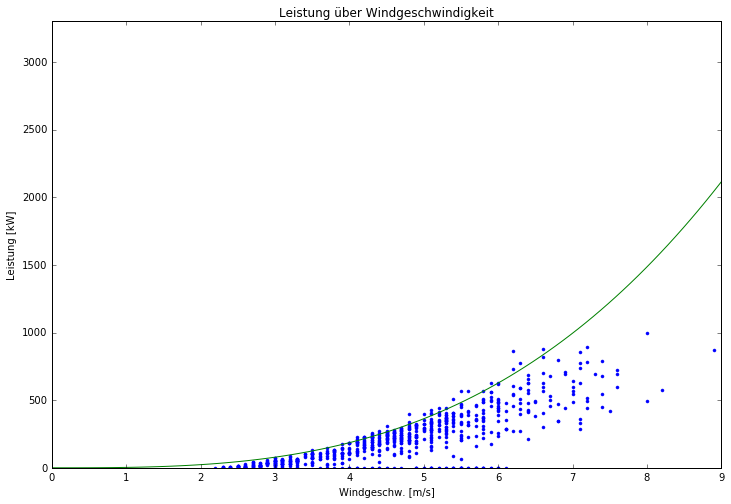

In [8]:
fig=plt.figure(figsize=(12,8))
plt.plot(df[u'MitVwind'],df[[u'MitP']],'.')
x1,x2,y1,y2 = plt.axis()
v=np.linspace(0,10,100)
power=2.9*v**3
plt.plot(v,power)
plt.axis((0,x2,0,3300));
plt.xlabel("Windgeschw. [m/s]")
plt.ylabel("Leistung [kW]");
plt.title(u'Leistung über Windgeschwindigkeit');

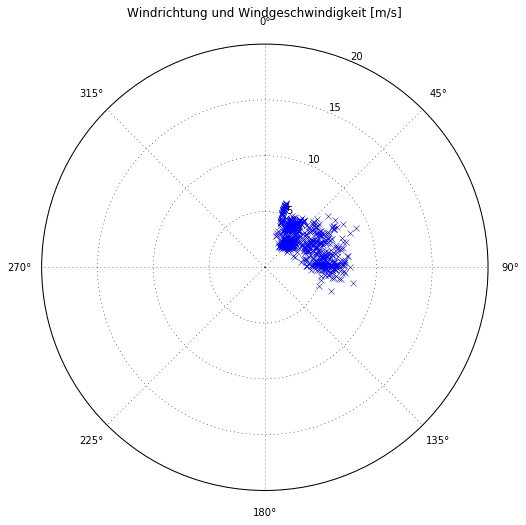

In [9]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.plot(np.pi+df[[u'GoPos']].values*np.pi/180,df[[u'MitVwind']].values,'x')
ax.set_theta_zero_location("N")
ax.set_rmax(20)
ax.grid(True)
plt.title('Windrichtung und Windgeschwindigkeit [m/s]');

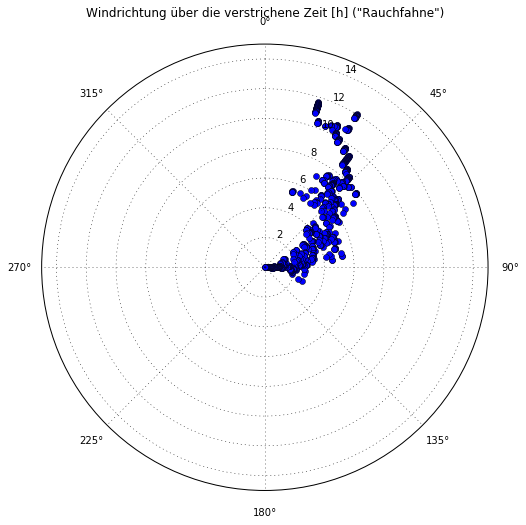

In [10]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.plot(np.pi+df[[u'GoPos']].values*np.pi/180,(df.index.values.max()-df.index.values).astype(float)/(1000000000*3600),'o')
ax.set_theta_zero_location("N")
ax.set_rmax(15)
ax.grid(True)
plt.title(u'Windrichtung über die verstrichene Zeit [h] ("Rauchfahne")');

## Daten der letzten 12 Stunden

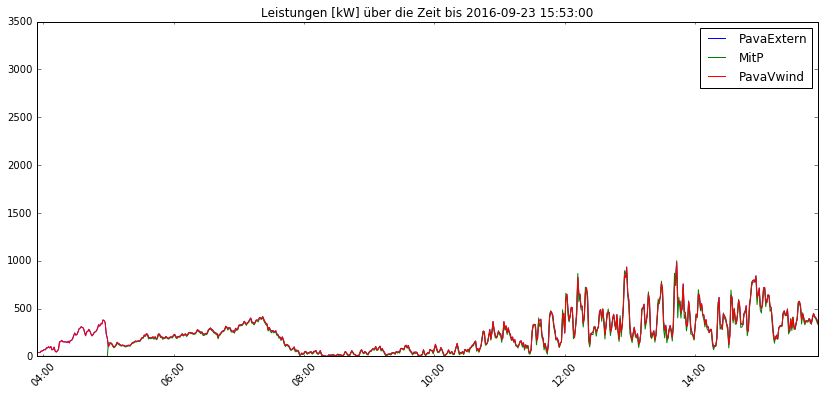

In [18]:
df[[u'PavaExtern','MitP','PavaVwind']].plot(rot=45,ylim=(0,3500),figsize=(14,6))
plt.title(u'Leistungen [kW] über die Zeit bis '+str(df.index[-1]));
plt.savefig('Egneos-Power-letzten12Stunden.png')

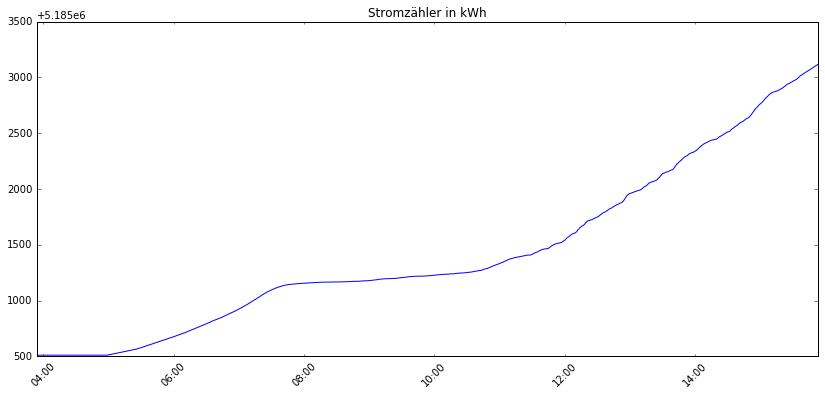

In [23]:
df['Wexp'].plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

## Daten der letzten 7 Tage

In [24]:
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Rep limit 1008 offset (select count(*) FROM Wecstd_Rep)-1008'
                       , disk_engine)
#aller 10Min.:6 pro Stunde mal 24 mal 7 = 1008
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
print "df-Shape: ",df.shape

df-Shape:  (1008, 31)


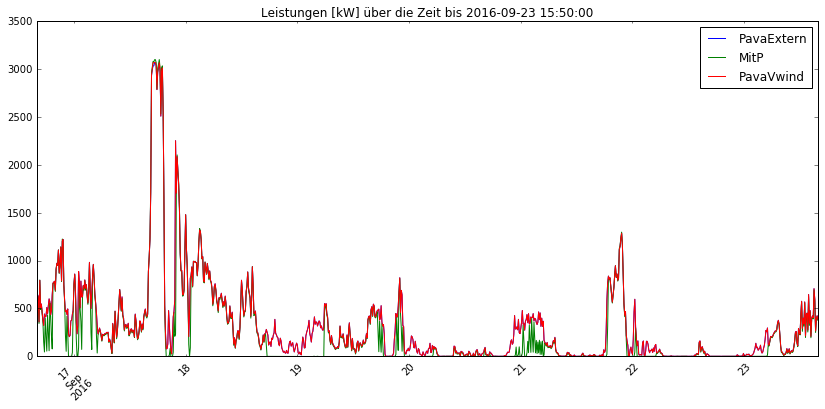

In [25]:
df[[u'PavaExtern','MitP','PavaVwind']].plot(rot=45,ylim=(0,3500),figsize=(14,6))
plt.title(u'Leistungen [kW] über die Zeit bis '+str(df.index[-1]));
plt.savefig('Egneos-Power-letzten7Tage.png')

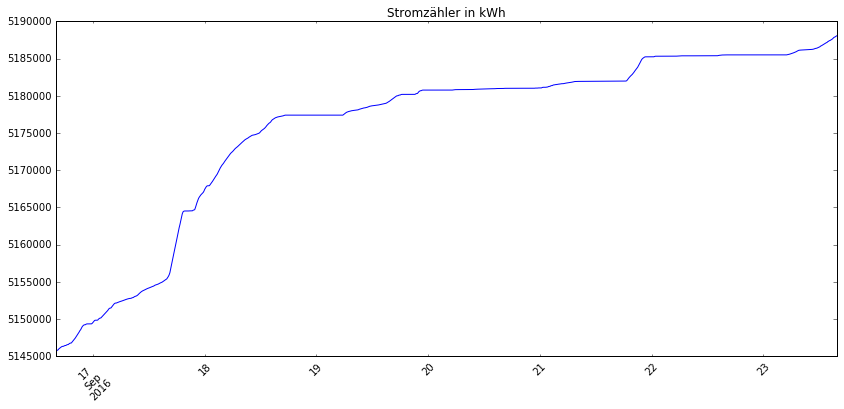

In [26]:
df['Wexp'].plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

## Daten des letzten 30 Tage

In [27]:
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Rep limit 4320 offset (select count(*) FROM Wecstd_Rep)-4320'
                       , disk_engine)
#aller 10Min.:6 pro Stunde mal 24 mal 30 = 4320
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
print "df-Shape: ",df.shape

df-Shape:  (4320, 31)


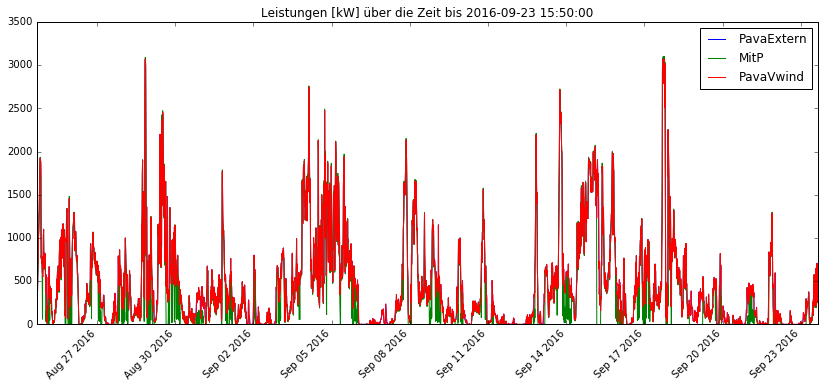

In [30]:
df[[u'PavaExtern','MitP','PavaVwind']].plot(rot=45,ylim=(0,3500),figsize=(14,6))
plt.title(u'Leistungen [kW] über die Zeit bis '+str(df.index[-1]));
plt.savefig('Egneos-Power-letzten30Tage.png')

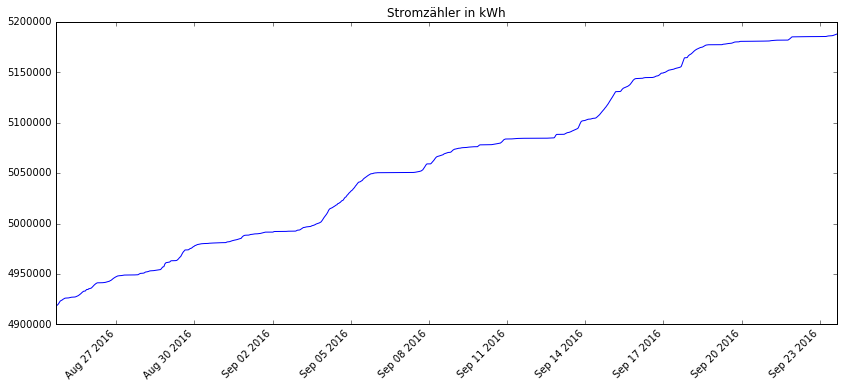

In [31]:
df['Wexp'].plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

## Langzeitdaten

In [32]:
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Day'
                       , disk_engine)
#aller 10Min.:6 pro Stunde mal 24 mal 30 = 4320
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
print "df-Shape: ",df.shape

df-Shape:  (282, 31)


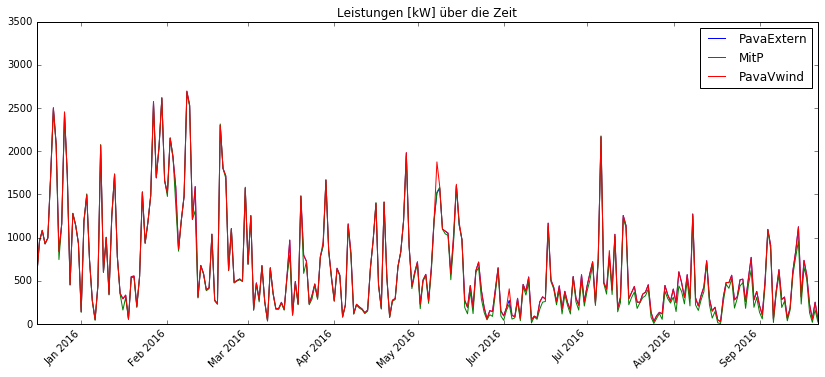

In [33]:
df[[u'PavaExtern','MitP','PavaVwind']].plot(rot=45,ylim=(0,3500),figsize=(14,6))
plt.title(u'Leistungen [kW] über die Zeit');
plt.savefig('Egneos-Power-alleTage.png')

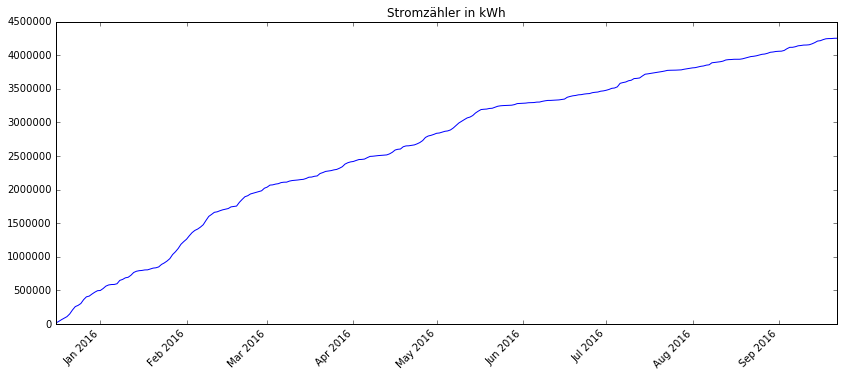

In [34]:
df['Wexp'].cumsum().plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

In [35]:
#Alle Daten
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Rep '
                       , disk_engine)
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
print "df-Shape: ",df.shape

df-Shape:  (31824, 31)


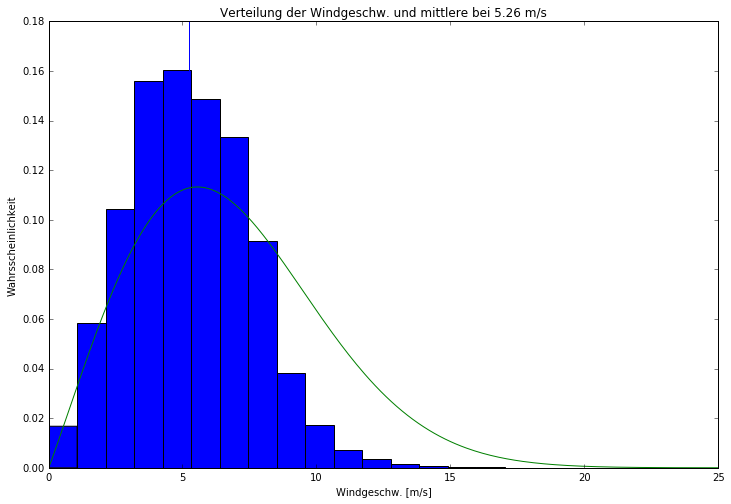

In [36]:
fig=plt.figure(figsize=(12,8))
plt.hist(df[[u'MitVwind']].values,normed=True,bins=20);
x1,x2,y1,y2 = plt.axis()
plt.axis((0,x2,0,y2));
mean=df[[u'MitVwind']].mean().values[0]
plt.axvline(mean);
rv = scipy.stats.exponweib(1.0, 2.05, scale=7.7)  #Prognose mit mittel. vWind 7.7m/s, k=2.05 und x=1 ?
x_range = np.arange(0, 30, 0.1)
plt.plot(x_range, rv.pdf(x_range));
plt.title('Verteilung der Windgeschw. und mittlere bei ' +"%.2f"% mean +" m/s")
plt.xlabel("Windgeschw. [m/s]")
plt.ylabel("Wahrsscheinlichkeit"); #ToDo Weibull-Verteilung;

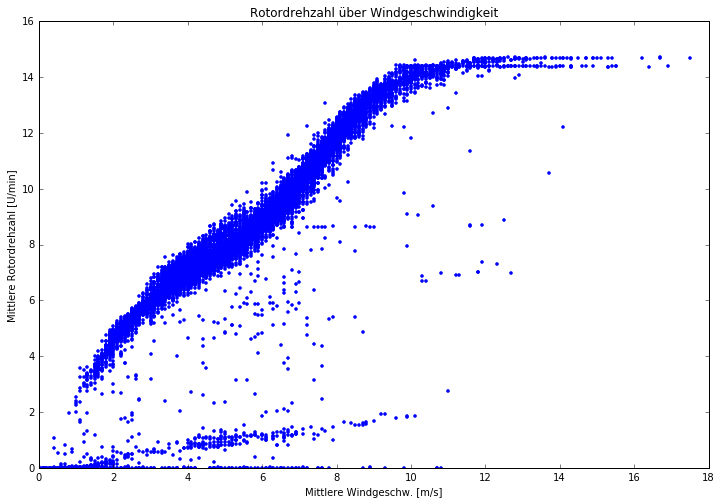

In [23]:
fig=plt.figure(figsize=(12,8))
plt.plot(df[u'MitVwind'].values  ,df[[u'MitNRotor']].values,'.')
plt.xlabel(u'Mittlere Windgeschw. [m/s]')
plt.ylabel(u'Mittlere Rotordrehzahl [U/min]')
x1,x2,y1,y2 = plt.axis()
plt.axis((0,x2,0,y2));
plt.title(u'Rotordrehzahl über Windgeschwindigkeit');

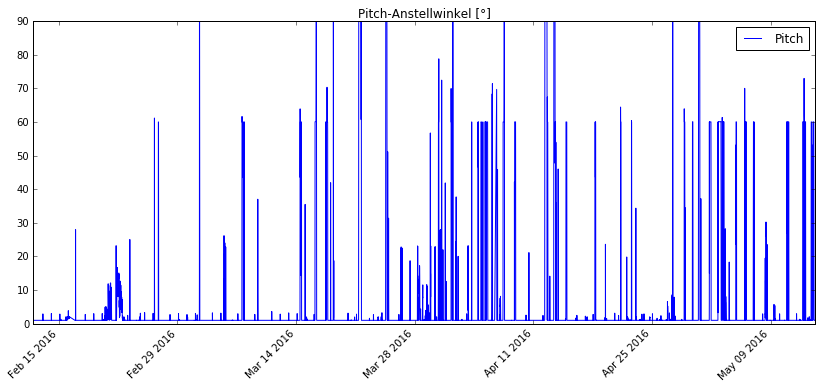

In [24]:
df[[u'Pitch']].plot(rot=45,ylim=(0,90),figsize=(14,6));
plt.title(u'Pitch-Anstellwinkel [°]');

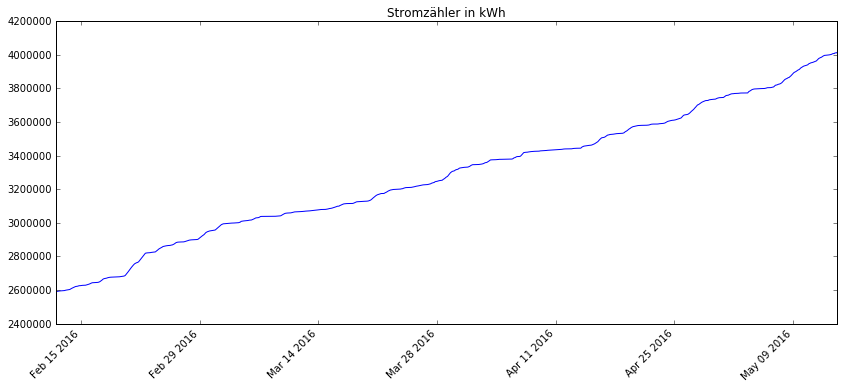

In [25]:
df['Wexp'].plot(rot=45,figsize=(14,6));
plt.title(u'Stromzähler in kWh');

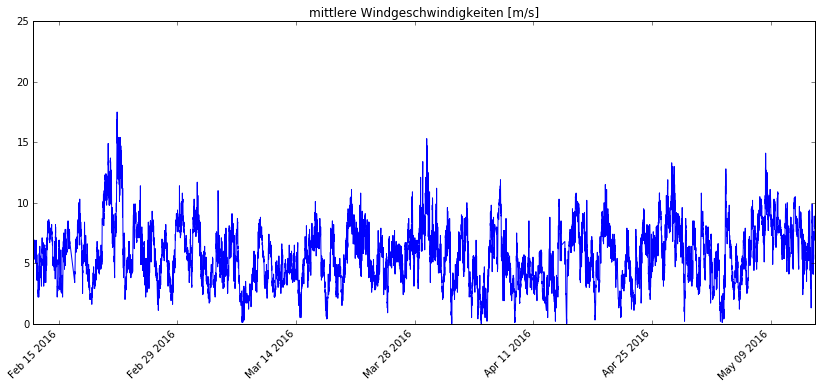

In [26]:
df.MitVwind.plot(rot=45,ylim=(0,25),figsize=(14,6));
plt.title(u'mittlere Windgeschwindigkeiten [m/s]');

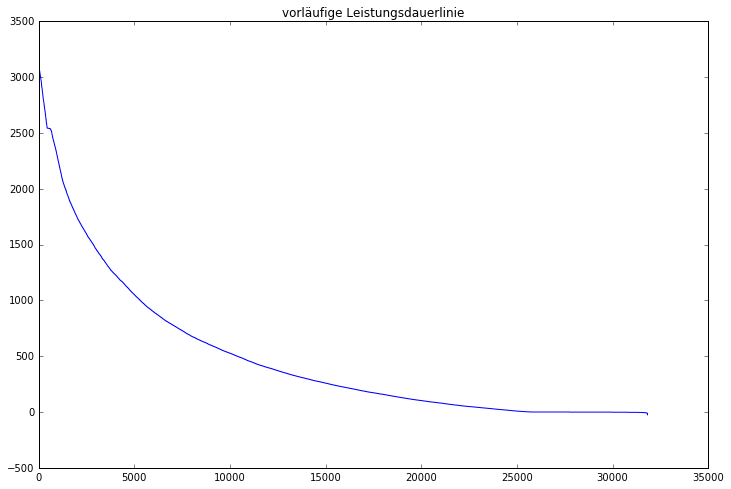

In [39]:
fig=plt.figure(figsize=(12,8))
plt.plot(-np.sort(-df['MitP'].values))
plt.title(u'vorläufige Leistungsdauerlinie');

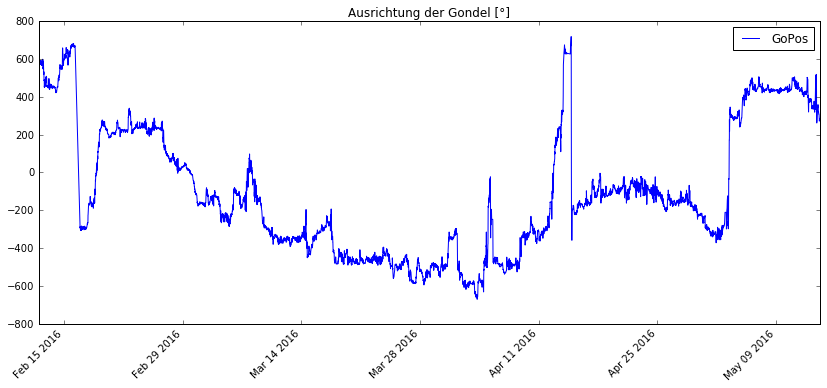

In [28]:
df[['GoPos']].plot(rot=45,figsize=(14,6));
plt.title(u'Ausrichtung der Gondel [°]');

## Temperaturen

In [29]:
df_temp = pd.read_sql_query('SELECT *'
                       ' FROM T101a1_Rep limit 15000 offset (select count(*) FROM T101a1_Rep)-15000'
                       , disk_engine)

df_temp.index=pd.DatetimeIndex(df_temp["index"])
df_temp.drop('index', axis=1, inplace=True)
df_temp.shape

(11249, 27)

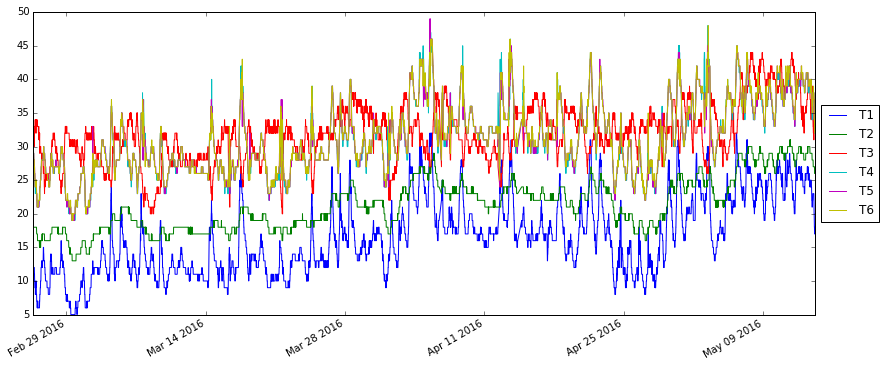

In [30]:
df_temp.ix[:,2:8].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

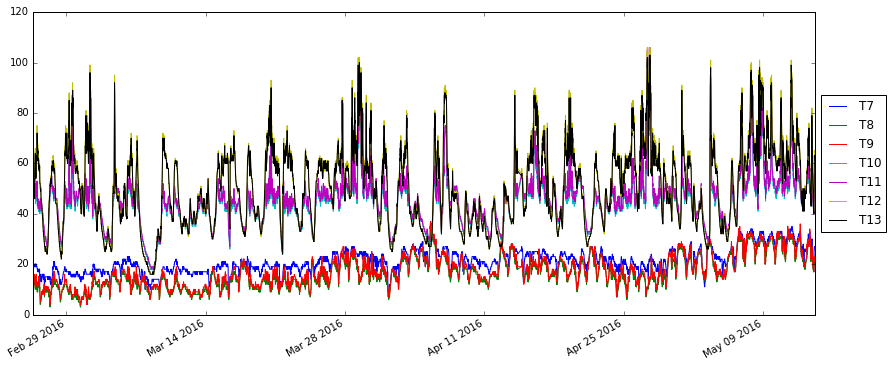

In [31]:
df_temp.ix[:,8:15].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

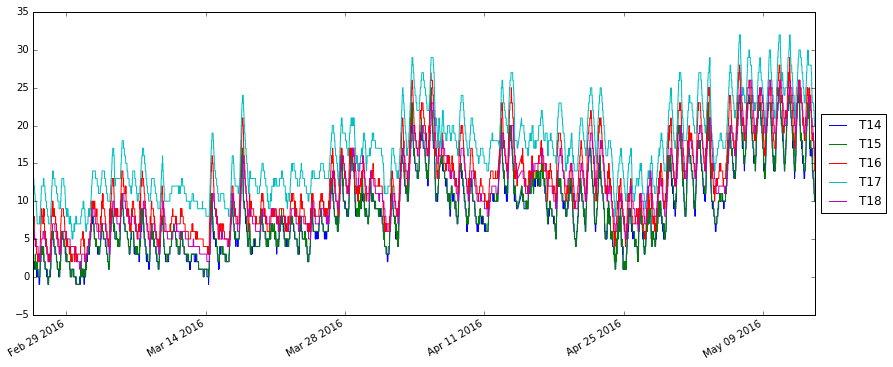

In [32]:
df_temp.ix[:,15:20].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

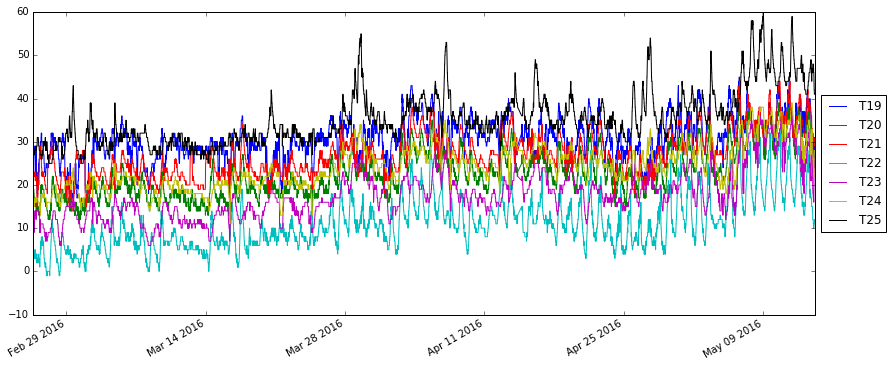

In [33]:
df_temp.ix[:,20:].plot(figsize=(14,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5));

## zukünftige Ziele
* mehr Auswertungen ermöglichen / interaktive Diagramme
* ggf. Integration der Egneos Solaranlage
* Bereitstellung des Datenbankzugangs (nach Absprache)
* Bereitstellung der Software an andere Energiegenossenschaften und Energiewendler (Github)
* andere externe Sensoren (Luftdruckänderung, Luftfeuchte -> Raspberry Pi Sense-Hat)
* Nutzung spezieller Datenstandards (MQTT, OpenEnergyMonitor (https://emoncms.org/), Sensor Observation Service,  Sensornetzwerke http://codeforchemnitz.de/projects/sensor/)

* kleines Webseiten-Widget mit aktuellen Daten 
* Integrationsmöglichkeiten von Verbrauchsdaten
* Excel-Unterstützung (wenn gewünscht)
* Live-Daten auf Telefon und Smart-Watches ...